In [1]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from model import RiceClassifier
from data import RiceDataset, get_transform
import torch
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import cv2

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

In [2]:
classes = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
classes_dict = {i: cls for i, cls in enumerate(classes)}

In [3]:
def load_val_dataset(input_dir=Path('../../data/Rice_Image_Dataset/'), val_ratio=0.2, num_workers=6, batch_size=16):
    dataset = RiceDataset(input_dir, transform=get_transform())
    val_amount = int(val_ratio * len(dataset))
    train_amount = len(dataset) - val_amount
    _, val_dataset = torch.utils.data.random_split(dataset, (train_amount, val_amount),
                                                   generator=torch.Generator().manual_seed(42))
    
    val_loader = torch.utils.data.DataLoader(val_dataset, num_workers=num_workers, batch_size=batch_size,
                                             drop_last=False)
    return val_dataset, val_loader

In [4]:
dataset, dataloader = load_val_dataset()

## ResNet

In [5]:
RESNET_WEIGHTS_PATH = 'inference/resnet.pt'

In [6]:
model = RiceClassifier('resnet18')
model.load_state_dict(torch.load(RESNET_WEIGHTS_PATH))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 25.5MB/s]


<All keys matched successfully>

In [7]:
model.eval();

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
model.to(device);

In [10]:
preds_list = []
targets_list = []
for imgs, targets in tqdm(dataloader):
    with torch.no_grad():
        imgs = imgs.to(device)
        targets = targets.to(device)
        preds = model.forward(imgs)
        preds = torch.argmax(preds, -1)
        preds = preds.cpu().numpy()
        targets = targets.cpu().numpy()
        preds_list.append(preds)
        targets_list.append(targets)

100%|████████████████████████████████████████| 938/938 [00:09<00:00, 100.12it/s]


In [11]:
y_preds = np.concatenate(preds_list)
y_true = np.concatenate(targets_list)

In [12]:
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3015
           1       1.00      1.00      1.00      2968
           2       1.00      1.00      1.00      2980
           3       1.00      1.00      1.00      3064
           4       1.00      1.00      1.00      2973

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



In [13]:
(y_preds == y_true).mean()

0.9992

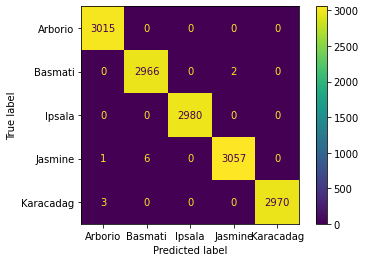

In [14]:
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()

In [15]:
def transform():
    trans = transforms.Compose([transforms.Normalize(mean=[0., 0., 0.], std = [1 / 0.229, 1 / 0.224, 1 / 0.225]),
                                transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])])
    
    return trans

trans = transform()

In [16]:
indices = np.where(y_true != y_preds)[0]
indices

array([ 3673,  4110,  5366,  6184,  7166,  7554,  7577, 10869, 10960,
       11134, 11138, 14392])

In [17]:
def plot_wrong(indices, preds, ncols, nrows):
    fig = plt.figure(figsize=(8 * ncols, 8 * nrows), dpi=90)
    gridspec = fig.add_gridspec(ncols=ncols, nrows=nrows)
    for i, idx in enumerate(indices):
        img, gt_cls = dataset[idx]
        img = trans(dataset[idx][0]).numpy().transpose((1, 2, 0))
        row = i // ncols
        col = i % ncols
        if row >= nrows:
            break
        ax = fig.add_subplot(gridspec[i:i+1])
        ax.title.set_text(f'TRUE: {classes_dict[gt_cls]}  |  PREDICTED: {classes_dict[preds[idx]]}')
        ax.imshow(img)
        plt.sca(ax)

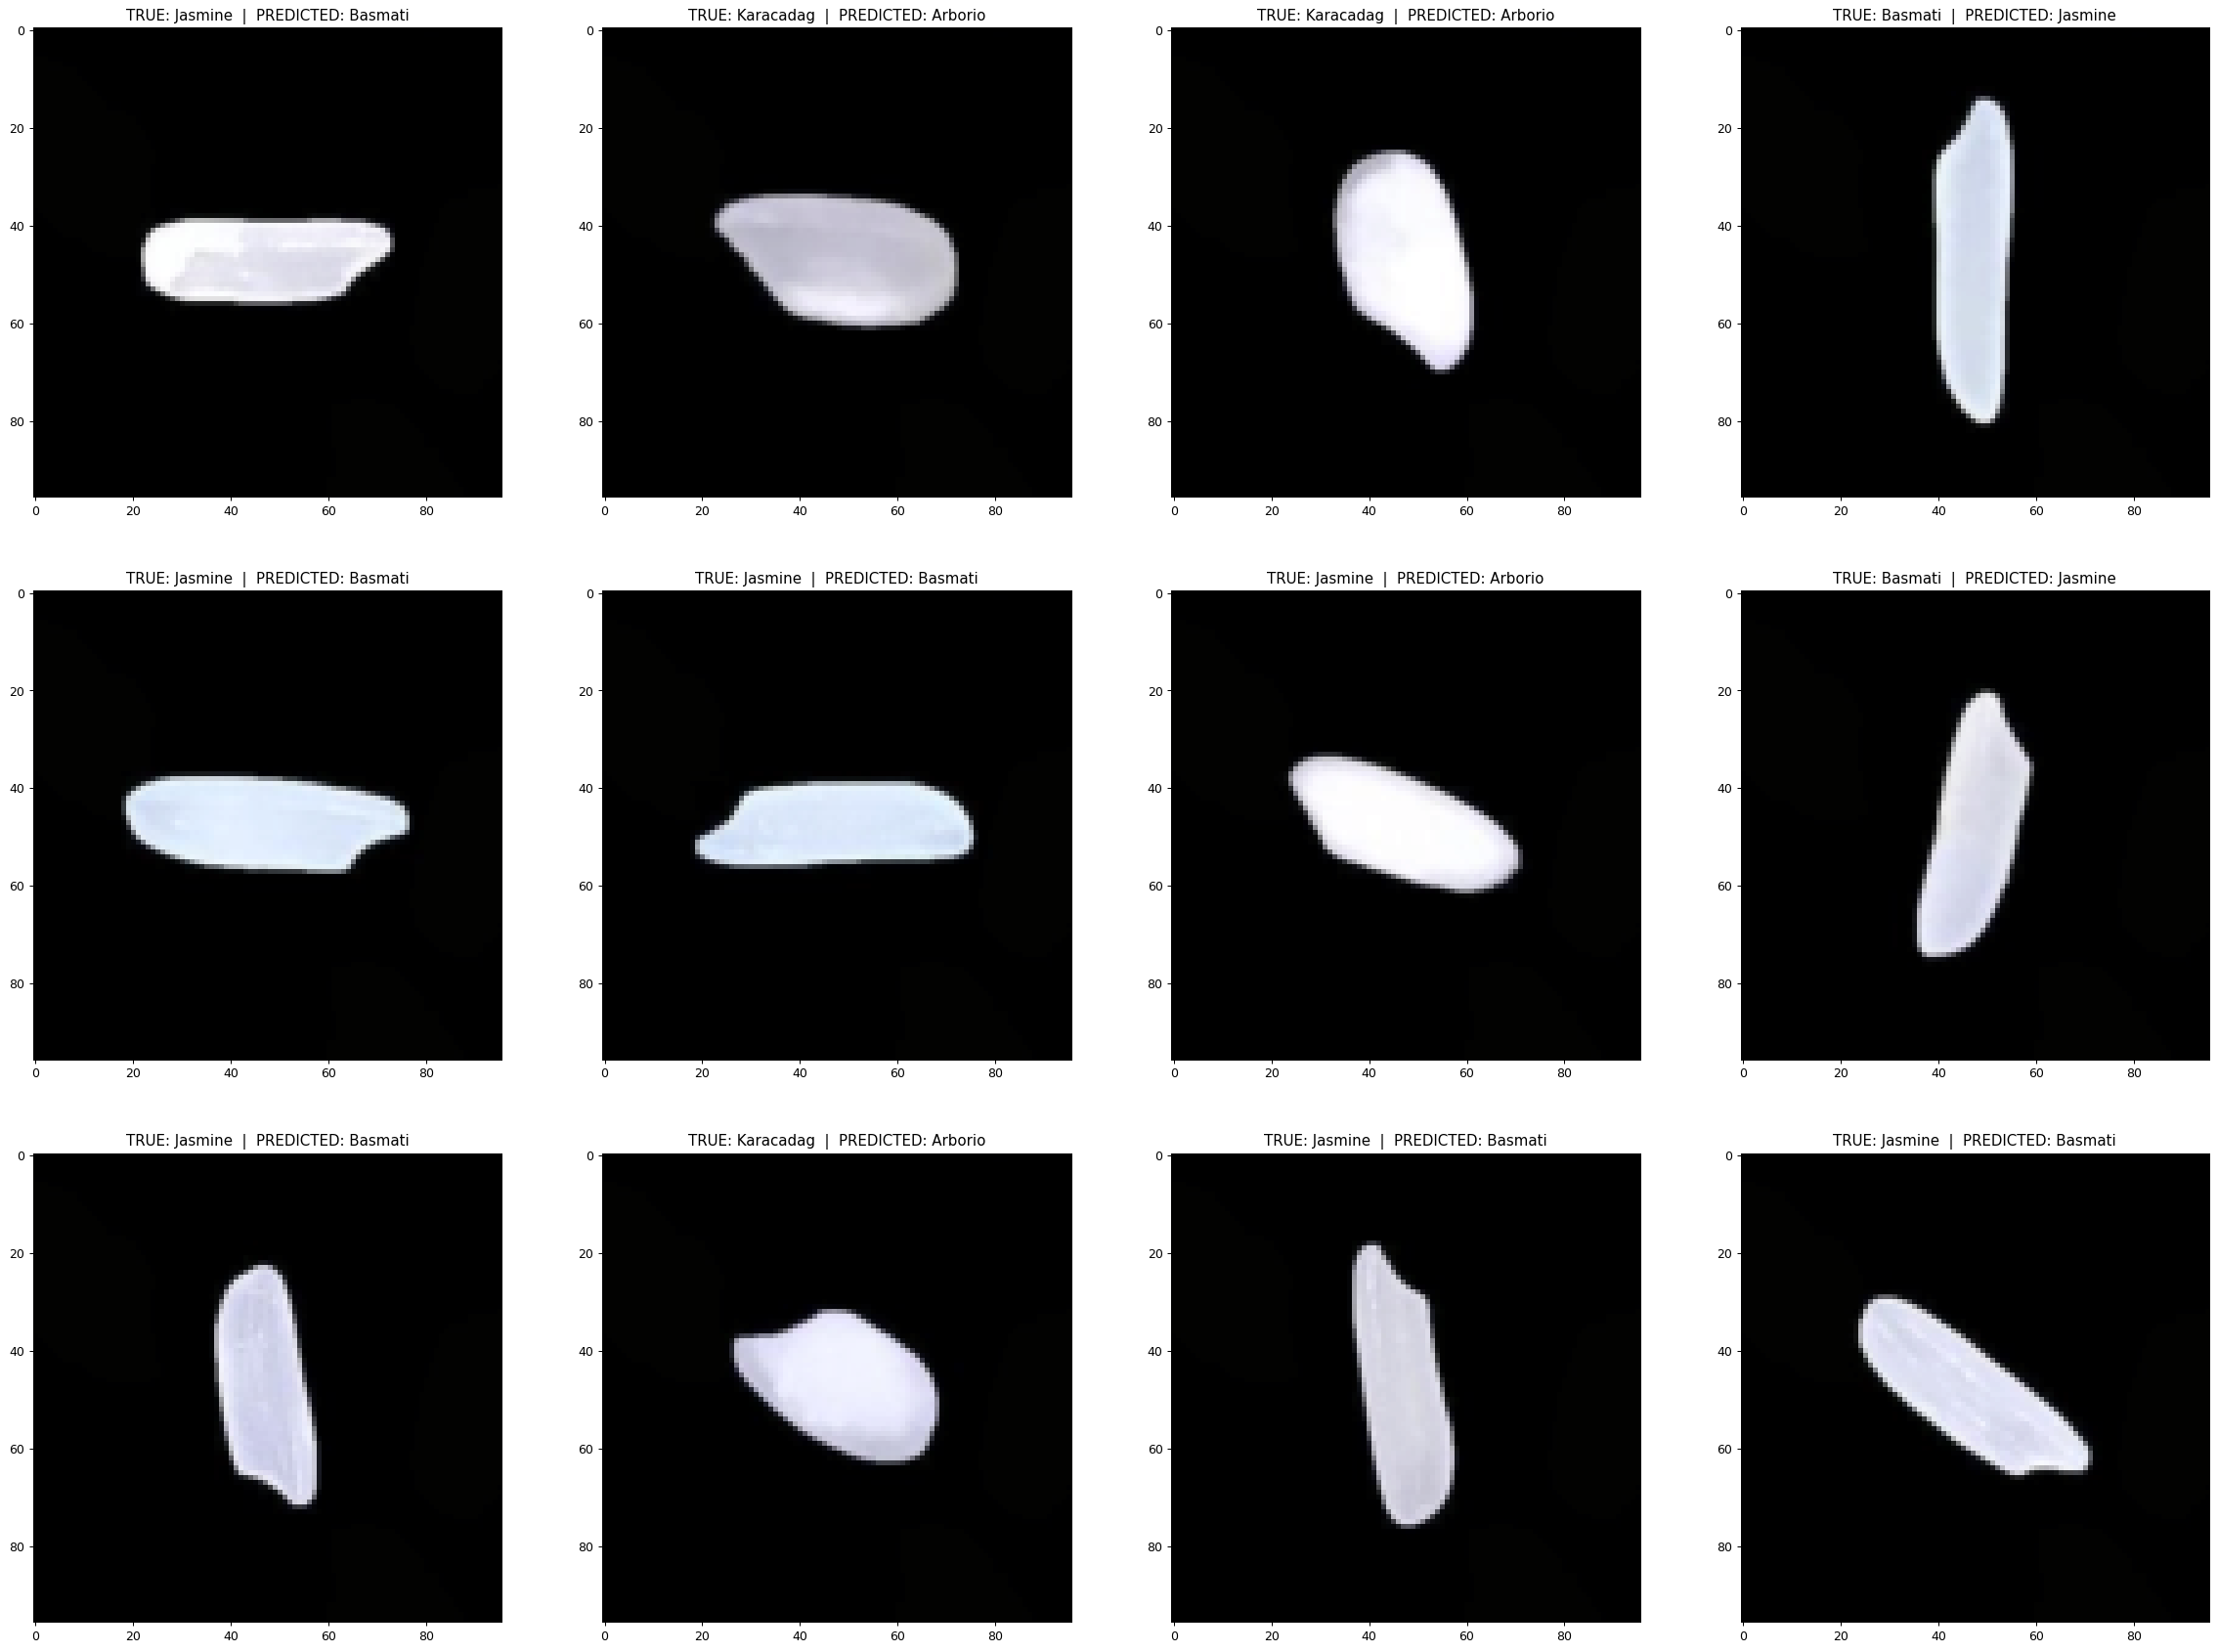

In [18]:
plot_wrong(indices, y_preds, 4, 3)

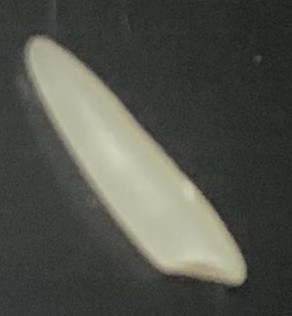

In [20]:
basmati1 = Image.open('../../ryz1.jpg')
basmati2 = Image.open('../../ryz2.jpg')
basmati1

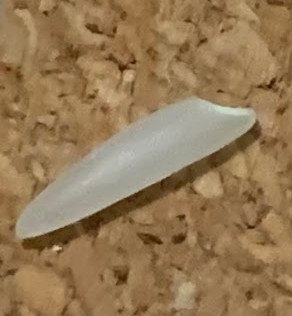

In [21]:
basmati2

In [22]:
transform = get_transform()

In [23]:
img = cv2.imread('../../ryz1.jpg')

In [24]:
_, mask = cv2.threshold(img, 127, 255,cv2.THRESH_TOZERO)

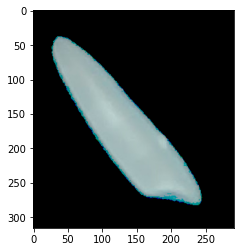

In [25]:
plt.imshow(mask)

In [26]:
basmati1_tensor = transform(Image.fromarray(mask))

In [27]:
img = cv2.imread('../../ryz2.jpg')

In [28]:
_, mask2 = cv2.threshold(img, 127, 255,cv2.THRESH_TOZERO)

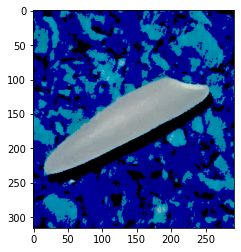

In [29]:
plt.imshow(mask2)

In [30]:
basmati2_tensor = transform(Image.fromarray(mask2))

In [31]:
torch.softmax(model(torch.stack([basmati1_tensor, basmati2_tensor]).cuda()), axis=-1)

tensor([[1.7510e-09, 3.4569e-15, 3.9892e-13, 1.0000e+00, 1.0407e-15],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.5588e-30]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

## EfficientNet

In [32]:
EFFICIENT_WEIGHTS_PATH = 'inference_efficientnet/efficientnet.pt'

In [33]:
model = RiceClassifier('efficientnet_b0')
model.load_state_dict(torch.load(EFFICIENT_WEIGHTS_PATH))

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████████████████████████████████| 20.5M/20.5M [00:00<00:00, 39.8MB/s]


<All keys matched successfully>

In [34]:
model.eval();

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [36]:
model.to(device);

In [37]:
preds_list = []
targets_list = []
for imgs, targets in tqdm(dataloader):
    with torch.no_grad():
        imgs = imgs.to(device)
        targets = targets.to(device)
        preds = model.forward(imgs)
        preds = torch.argmax(preds, -1)
        preds = preds.cpu().numpy()
        targets = targets.cpu().numpy()
        preds_list.append(preds)
        targets_list.append(targets)

100%|█████████████████████████████████████████| 938/938 [00:11<00:00, 80.74it/s]


In [38]:
y_preds = np.concatenate(preds_list)
y_true = np.concatenate(targets_list)

In [39]:
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3015
           1       1.00      1.00      1.00      2968
           2       1.00      1.00      1.00      2980
           3       1.00      1.00      1.00      3064
           4       1.00      1.00      1.00      2973

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



In [40]:
(y_preds == y_true).mean()

0.9994666666666666

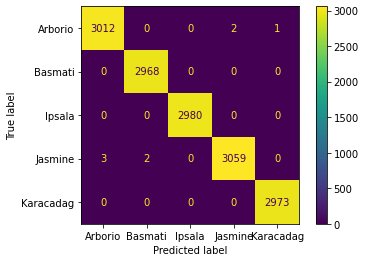

In [41]:
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()

In [42]:
indices = np.where(y_true != y_preds)[0]
indices

array([ 2503,  3358,  7319,  8058,  9159, 11375, 12006, 12528])

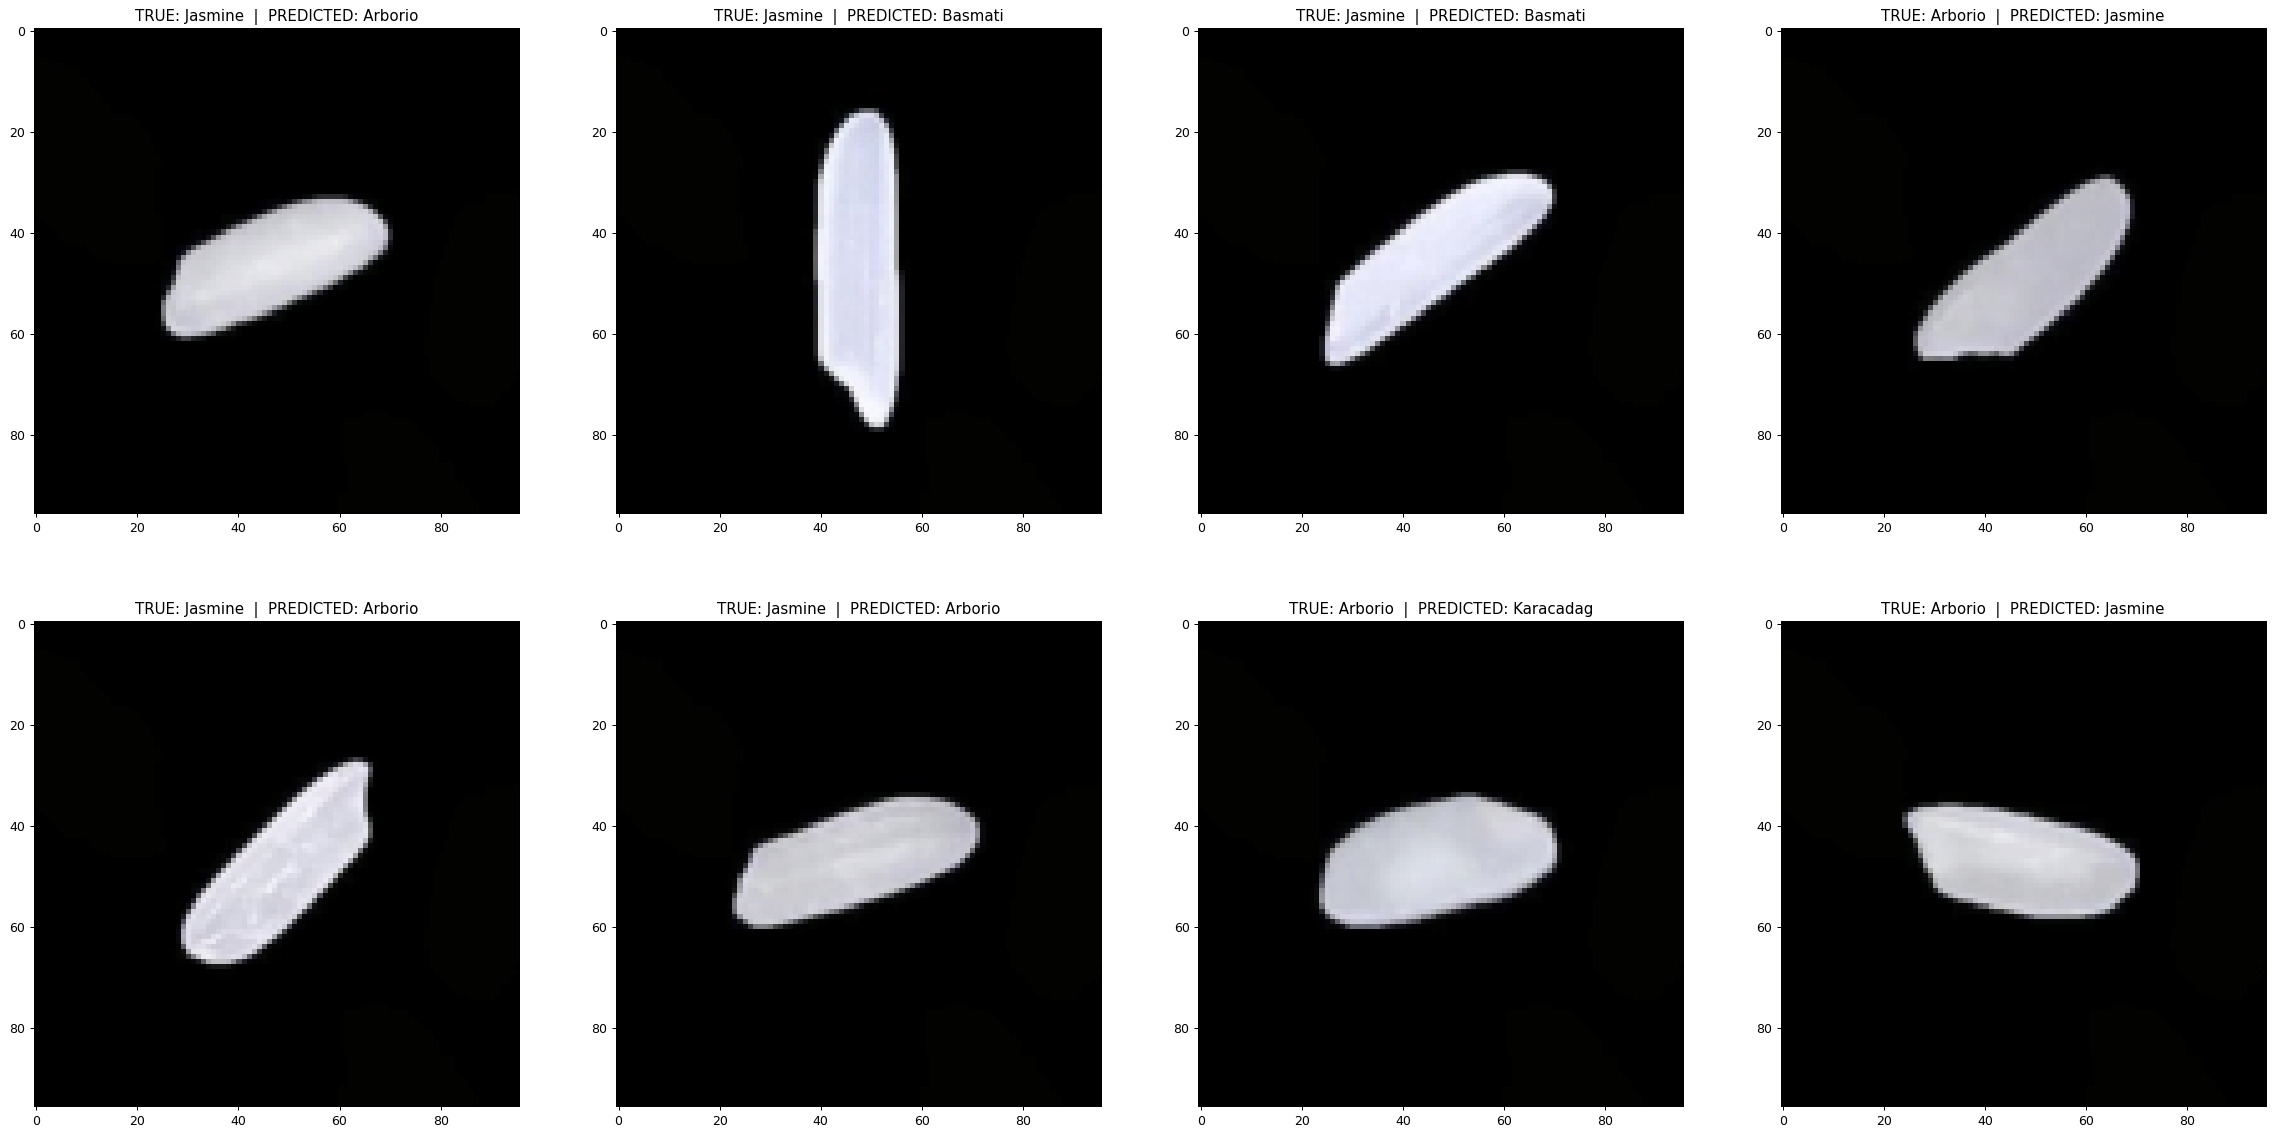

In [43]:
plot_wrong(indices, y_preds, 4, 2)

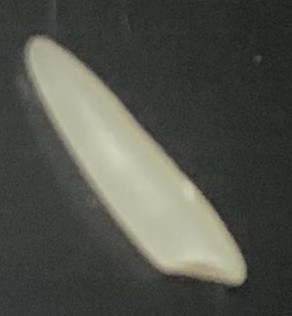

In [45]:
basmati1 = Image.open('../../ryz1.jpg')
basmati2 = Image.open('../../ryz2.jpg')
basmati1

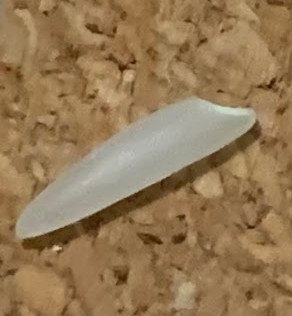

In [47]:
basmati2

In [48]:
basmati1_tensor = transform(basmati1)

In [49]:
basmati2_tensor = transform(basmati2)

In [50]:
torch.softmax(model(torch.stack([basmati1_tensor, basmati2_tensor]).cuda()), axis=-1)

tensor([[6.3591e-05, 8.8221e-11, 5.2093e-13, 9.9994e-01, 6.0830e-12],
        [2.6034e-04, 2.2942e-17, 4.1151e-22, 9.9974e-01, 6.5170e-17]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [54]:
basmati1_tensor_mask = transform(Image.fromarray(mask))

In [55]:
img = cv2.imread('../../ryz2.jpg')

In [56]:
_, mask2 = cv2.threshold(img, 127, 255,cv2.THRESH_TOZERO)

In [57]:
basmati2_tensor = transform(Image.fromarray(mask2))

In [58]:
torch.softmax(model(torch.stack([basmati1_tensor_mask, basmati2_tensor]).cuda()), axis=-1)

tensor([[1.6550e-05, 1.1791e-11, 4.2088e-15, 9.9998e-01, 2.8725e-11],
        [2.8505e-04, 1.0417e-05, 2.1733e-09, 9.9970e-01, 1.2500e-07]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)